# Non-personalized recommandation

In [81]:
# Imports

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from itertools import permutations
from time import time
import contextlib

@contextlib.contextmanager
def timer(msg='timer'):
    tic = time()
    yield
    return print(f"{msg}: {time() - tic:.2f}")

In [8]:
movies_df = pd.read_csv("./Data/MovieLens/ml-latest-small/movies.csv", index_col=0)
ratings_df = pd.read_csv("./Data/MovieLens/ml-latest-small/ratings.csv", index_col=0)
user_ratings_df = pd.read_csv("./Data/MovieLens/Processed/user_rating.csv", index_col=0)
user_ratings_df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,1,3,4.0,Grumpier Old Men (1995)
2,1,6,4.0,Heat (1995)
3,1,47,5.0,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,"Usual Suspects, The (1995)"


# Which are the most viewed movies?

In [3]:
user_ratings_df['title'].value_counts().head(20)

Forrest Gump (1994)                                                               329
Shawshank Redemption, The (1994)                                                  317
Pulp Fiction (1994)                                                               307
Silence of the Lambs, The (1991)                                                  279
Matrix, The (1999)                                                                278
Star Wars: Episode IV - A New Hope (1977)                                         251
Jurassic Park (1993)                                                              238
Braveheart (1995)                                                                 237
Terminator 2: Judgment Day (1991)                                                 224
Schindler's List (1993)                                                           220
Fight Club (1999)                                                                 218
Toy Story (1995)                                      

# Which are the best rated movies?

In [4]:
num_ratings = user_ratings_df['title'].value_counts()
mean_ratings = user_ratings_df[['title','rating']].groupby('title').mean().sort_values(by='rating',ascending=False)
mean_ratings['number of ratings'] = num_ratings
mean_ratings.head()

,rating,number of ratings
title,,
Gena the Crocodile (1969),5.0,1
True Stories (1986),5.0,1
Cosmic Scrat-tastrophe (2015),5.0,1
Love and Pigeons (1985),5.0,1
Red Sorghum (Hong gao liang) (1987),5.0,1


The movies with the highest ratings tend to be rather obscure movies with only a few ratings. Let's apply a lower cutoff on the number of ratings to recommend movies that are both highly rated and popular

In [5]:
thr = 50
mean_ratings_thr = mean_ratings[mean_ratings['number of ratings']>thr]
mean_ratings_thr.head(10)

,rating,number of ratings
title,,
"Shawshank Redemption, The (1994)",4.429022,317
"Godfather, The (1972)",4.289062,192
Fight Club (1999),4.272936,218
Cool Hand Luke (1967),4.271930,57
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),4.268041,97
Rear Window (1954),4.261905,84
"Godfather: Part II, The (1974)",4.259690,129
"Departed, The (2006)",4.252336,107
Goodfellas (1990),4.250000,126


# Most commonly seen together items

## Method 1: create a co-occurence matrix (efficient)

In [107]:
# Create a matrix to store the count of movie permutations



timer: 10.20


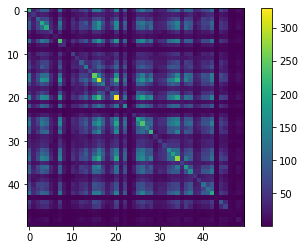

In [214]:
# Here we take advantage of the fact that movies are numbered from 1 to num_movies
# If movieId were not continuous we would need an extra mapping function between movieId and the indices in the matrix
# Note: if the data were really large, perm_mat could be built blockwise and converted to sparse matrix format
# we could also take advantage of the fact that the matrix is triangular to that one half doesn't need to be computer or stored
movie_list = user_ratings_df['movieId'].unique()
num_movies = len(movie_list)

MAP_movies = dict(zip(movie_list,range(num_movies)))
co_occ_mat = np.zeros((num_movies, num_movies))
with timer():
    for user in ratings_df.index.unique():
        movies = ratings_df.loc[user,'movieId'].values
        movies = list(map(lambda x: MAP_movies[x], movies))
        for movie in movies:
            co_occ_mat[movie, movies] += 1
        
# Visualize a small portion of the matrix
plt.imshow(co_occ_mat[:50,:50])
plt.colorbar()

## Method 2: Datacamp course method (sloooow)

In [220]:
from itertools import permutations

# Create the function to find all permutations
def find_movie_pairs(x):
  pairs = pd.DataFrame(list(permutations(x.values, 2)),
                       columns=['movie_a', 'movie_b'])
  return pairs

# Apply the function to the title column and reset the index
with timer():
    movie_combinations = user_ratings_df.groupby('userId')['title'].apply(find_movie_pairs).reset_index(drop=True)

movie_combinations.head()

timer: 26.23


,movie_a,movie_b
0,Toy Story (1995),Grumpier Old Men (1995)
1,Toy Story (1995),Heat (1995)
2,Toy Story (1995),Seven (a.k.a. Se7en) (1995)
3,Toy Story (1995),"Usual Suspects, The (1995)"
4,Toy Story (1995),From Dusk Till Dawn (1996)


In [221]:
with timer():# Calculate how often each item in movie_a occurs with the items in movie_b
    combination_counts = movie_combinations.groupby(['movie_a', 'movie_b']).size()

    # Convert the results to a DataFrame and reset the index
    combination_counts_df = combination_counts.to_frame(name='size').reset_index()
combination_counts_df.head()

timer: 32.57


,movie_a,movie_b,size
0,'71 (2014),(500) Days of Summer (2009),1
1,'71 (2014),10 Cloverfield Lane (2016),1
2,'71 (2014),127 Hours (2010),1
3,'71 (2014),13 Assassins (Jûsan-nin no shikaku) (2010),1
4,'71 (2014),13 Hours (2016),1


## Verify that the two methods give the same results

In [217]:
movie_title = 'Jack (1996)'

In [224]:
# Method 1
movieId = movies_df.loc[movies_df['title']==movie_title].index[0]
matId = MAP_movies[movieId]
temp = pd.DataFrame({'movieId': movie_list, 'size':co_occ_mat[matId,:]})
temp['title'] = movies_df.loc[temp['movieId'],'title'].values
temp.sort_values(by='size',ascending=False).head(10)

,movieId,size,title
690,765,19.0,Jack (1996)
42,780,14.0,Independence Day (a.k.a. ID4) (1996)
20,356,14.0,Forrest Gump (1994)
470,344,13.0,Ace Ventura: Pet Detective (1994)
1467,1367,13.0,101 Dalmatians (1996)
37,648,13.0,Mission: Impossible (1996)
16,296,12.0,Pulp Fiction (1994)
60,1073,12.0,Willy Wonka & the Chocolate Factory (1971)
292,32,12.0,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
41,736,12.0,Twister (1996)


In [225]:
# Method 2
combination_counts_df.loc[pair_counts_df['movie A']==movie_title].sort_values(by='size',ascending=False).head(5)

,movie_a,movie_b,size
12132739,Jack (1996),Forrest Gump (1994),14
12133215,Jack (1996),Independence Day (a.k.a. ID4) (1996),14
12131508,Jack (1996),Ace Ventura: Pet Detective (1994),13
12131436,Jack (1996),101 Dalmatians (1996),13
12133768,Jack (1996),Mission: Impossible (1996),13


Both methods yield the same results. Good! Here's a comparison between the two methods:

- Method 1 has the advantage of being fast, both to create the matrix and access the data. Also, it can be stored as an triangular sparse matrix, which would make it memory efficient. The disadvantage is that it needs to be coded by hand and I made quite a few bugs before I managed to set and retrieved the data correctly. Bugs were not easy to find since the data looked reasonable. Another advantage is that the data is easily visualized with a heatmap, and the structure is pretty transparent.

- Method 2 is WAAAY slower than method 1, both to generate the table and to access data. The creation of the table is also quite convoluted. Also, the titles need to be stored, and in the end it will take more space than method 1 (assuming that we would use a sparse matrix format). But there might be less chance of coding bugs because if it's coded improperly, the results will look nothing like what we want.